Saving Base_frutas.txt to Base_frutas.txt
Primeras filas:
   tipo_fruta   nombre  masa  anchura  altura
0           1  manzana   192      8.4     7.3
1           1  manzana   180      8.0     6.8
2           1  manzana   176      7.4     7.2
3           2     pera    86      6.2     4.7
4           2     pera    84      6.0     4.6

Forma del dataset: (59, 5)

Porcentaje de entrenamiento: 70.0%
Porcentaje de test: 30.0%


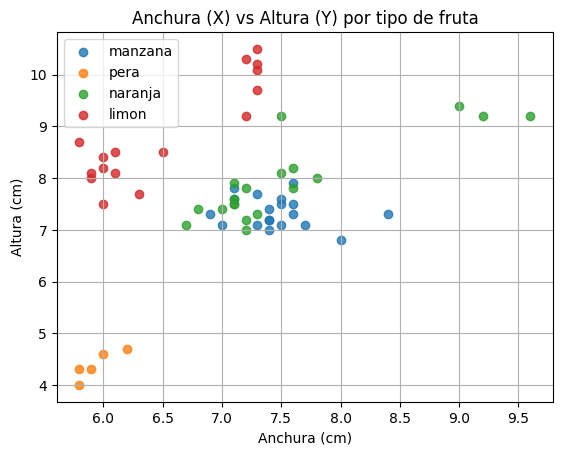

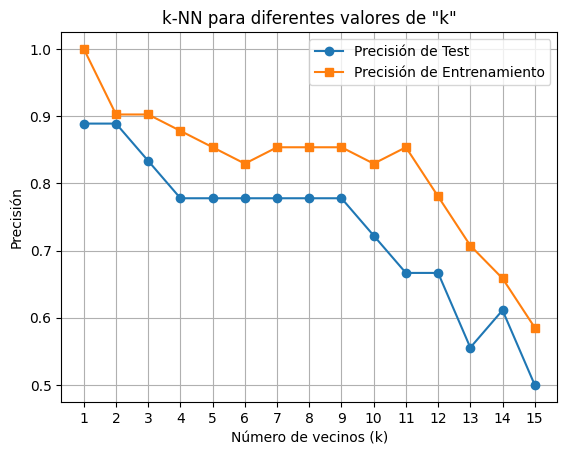


Mejor k elegido: 1
Accuracy (score) en test con k=1: 0.8889

Matriz de confusión (filas=verdadero, columnas=predicho):
 [[5 0 1 0]
 [0 1 0 0]
 [1 0 5 0]
 [0 0 0 5]]

Informe de clasificación:
              precision    recall  f1-score   support

     manzana       0.83      0.83      0.83         6
        pera       1.00      1.00      1.00         1
     naranja       0.83      0.83      0.83         6
       limon       1.00      1.00      1.00         5

    accuracy                           0.89        18
   macro avg       0.92      0.92      0.92        18
weighted avg       0.89      0.89      0.89        18


Predicciones:
  Caso 1 (100 gr, 6.3 cm, 8.0 cm) -> tipo_fruta 4 (limon)
  Caso 2 (300 gr, 8.8 cm, 9.2 cm) -> tipo_fruta 3 (naranja)


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from google.colab import files
uploaded = files.upload()

filename = next(iter(uploaded))

if filename.lower().endswith(".txt"):
    df = pd.read_csv(filename, sep=r"\s+", engine="python")
else:
    df = pd.read_csv(filename)

df.columns = [c.strip().lower() for c in df.columns]

for col in ["masa", "anchura", "altura", "tipo_fruta"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["tipo_fruta", "masa", "anchura", "altura"]).copy()
df["tipo_fruta"] = df["tipo_fruta"].astype(int)

print("Primeras filas:")
print(df.head())
print("\nForma del dataset:", df.shape)

if "nombre" in df.columns:
    nombre_map = (
        df.groupby("tipo_fruta")["nombre"]
        .agg(lambda s: s.mode().iat[0] if not s.mode().empty else str(int(s.name)))
        .to_dict()
    )
else:
    nombre_map = {}

X = df[["masa", "anchura", "altura"]].values
y = df["tipo_fruta"].values


TEST_SIZE = 0.30
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"\nPorcentaje de entrenamiento: {100*(1-TEST_SIZE):.1f}%")
print(f"Porcentaje de test: {100*TEST_SIZE:.1f}%")

plt.figure()
classes = np.unique(y)
for cls in classes:
    mask = df["tipo_fruta"] == cls
    plt.scatter(df.loc[mask, "anchura"], df.loc[mask, "altura"], label=nombre_map.get(cls, f"Clase {cls}"), alpha=0.8)

plt.title("Anchura (X) vs Altura (Y) por tipo de fruta")
plt.xlabel("Anchura (cm)")
plt.ylabel("Altura (cm)")
plt.grid(True)
plt.legend()
plt.show()


neighbors = np.arange(1, 16)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train, y_train)
    train_accuracy[i] = pipe.score(X_train, y_train)
    test_accuracy[i] = pipe.score(X_test, y_test)


plt.figure()
plt.title('k-NN para diferentes valores de "k"')
plt.plot(neighbors, test_accuracy, marker="o", label="Precisión de Test")
plt.plot(neighbors, train_accuracy, marker="s", label="Precisión de Entrenamiento")
plt.legend()
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Precisión")
plt.grid(True)
plt.xticks(neighbors)
plt.show()


best_k = int(neighbors[np.argmax(test_accuracy)])
print(f"\nMejor k elegido: {best_k}")


model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])
model.fit(X_train, y_train)

test_score = model.score(X_test, y_test)
print(f"Accuracy (score) en test con k={best_k}: {test_score:.4f}")


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión (filas=verdadero, columnas=predicho):\n", cm)
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=[nombre_map.get(c, f"Clase {c}") for c in classes]))

caso_1 = np.array([[100, 6.3, 8.0]])
caso_2 = np.array([[300, 8.8, 9.2]])

pred_1 = int(model.predict(caso_1)[0])
pred_2 = int(model.predict(caso_2)[0])

def nombre_fruta(c):
    return nombre_map.get(c, f"Clase {c}")

print("\nPredicciones:")
print(f"  Caso 1 (100 gr, 6.3 cm, 8.0 cm) -> tipo_fruta {pred_1} ({nombre_fruta(pred_1)})")
print(f"  Caso 2 (300 gr, 8.8 cm, 9.2 cm) -> tipo_fruta {pred_2} ({nombre_fruta(pred_2)})")
